# Classify Documents

## Load Data
The next cell will load embeddings generated in notebook [01-get-embeddings.ipynb](./01-get-embeddings.ipynb).

In [18]:
import pandas as pd

df_orig = pd.read_csv("data/bbc-news-data-embedding.csv", delimiter='\t', index_col=False)

In [19]:
df = df_orig.copy()
df

,category,filename,title,content,embedding
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...,"[-0.021155867725610733, -0.01682022027671337, ..."
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[-0.02455304190516472, -0.012937315739691257, ..."
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...,"[-0.021608199924230576, -0.036890752613544464,..."
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...,"[-0.02186358906328678, -0.016681300476193428, ..."
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.008347506634891033, -0.008401579223573208,..."
...,...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...,"[-0.022007180377840996, -0.009663669392466545,..."
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...,"[-0.005723385605961084, -0.0186212919652462, -..."
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...,"[0.0019429635722190142, -0.013848277740180492,..."
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...,"[-0.00036830714088864625, -0.02817297354340553..."


In [20]:
# drop rows with NaN
df.dropna(inplace=True)
len(df)

2225

In [21]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# convert string to array
df["embedding"] = df['embedding'].apply(eval).apply(np.array)  

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   category   2225 non-null   object
 1   filename   2225 non-null   object
 2   title      2225 non-null   object
 3   content    2225 non-null   object
 4   embedding  2225 non-null   object
dtypes: object(5)
memory usage: 87.0+ KB


In [22]:
X = df['embedding']
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True, stratify=y) 

# reshape X into 2D array
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)

In [24]:
y_train_encoded

array([0, 1, 3, ..., 1, 3, 2])

## Fit a model with `XGBoost`

In [9]:
pip install xgboost


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: /anaconda/envs/azureml_py310_sdkv2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
from xgboost import XGBClassifier
import pickle

TRAIN = False
LOAD = True

# filename for trained model
fname = 'output/xgb.pkl'

if TRAIN: 
    # create model instance
    xgb = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=1, objective='multi:softprob')
    # fit model
    xgb.fit(X_train, y_train_encoded)

    # save the model to disk
    with open(fname, "wb") as f:
        pickle.dump(xgb, f)
 
# load the model from disk
if LOAD:
    with open(fname, "rb") as f:
        xgb = pickle.load(f)

# predict
preds = xgb.predict(X_test)
probas = xgb.predict_proba(X_test)

# report
report = classification_report(y_test_encoded, preds)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       168
           1       0.95      0.95      0.95       128
           2       0.96      0.93      0.95       138
           3       0.98      0.99      0.99       169
           4       0.95      0.96      0.96       132

    accuracy                           0.96       735
   macro avg       0.96      0.96      0.96       735
weighted avg       0.96      0.96      0.96       735



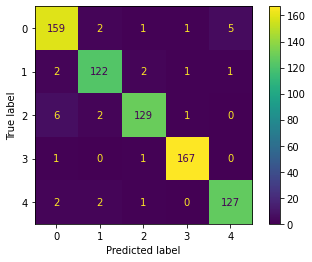

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# confusion matrix
cm = confusion_matrix(y_test_encoded, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb.classes_).plot()


## Save predictions

In [27]:
y_test_pred = pd.DataFrame()
y_test_pred['category'] = y_test
y_test_pred['prediction'] = preds
y_test_pred

,category,prediction
413,business,0
1690,sport,3
32,business,0
655,entertainment,1
48,business,0
...,...,...
1787,sport,3
840,entertainment,1
4,business,0
2089,tech,4


In [28]:
y_test_pred = pd.DataFrame()
y_test_pred['category'] = y_test
y_test_pred['encoded_category'] = y_test_encoded
y_test_pred['prediction'] = preds
y_test_pred


,category,encoded_category,prediction
413,business,0,0
1690,sport,3,3
32,business,0,0
655,entertainment,1,1
48,business,0,0
...,...,...,...
1787,sport,3,3
840,entertainment,1,1
4,business,0,0
2089,tech,4,4


In [29]:
df_test_result = pd.concat([df, y_test_pred.drop(columns='category')], axis=1, join="inner")
df_test_result.shape
df_test_result

,category,filename,title,content,embedding,encoded_category,prediction
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...,"[-0.02455304190516472, -0.012937315739691257, ...",0,0
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...,"[-0.008347506634891033, -0.008401579223573208,...",0,0
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...,"[-0.00852490309625864, -0.03030790016055107, -...",0,0
13,business,014.txt,Telegraph newspapers axe 90 jobs,The Daily and Sunday Telegraph newspapers are...,"[-0.010854844935238361, -0.0025832285173237324...",0,3
14,business,015.txt,Air passengers win new EU rights,Air passengers who are unable to board their ...,"[0.004284340422600508, -0.017877385020256042, ...",0,0
...,...,...,...,...,...,...,...
2211,tech,388.txt,Camera phones are 'must-haves',Four times more mobiles with cameras in them ...,"[0.002961941296234727, 0.01108421478420496, 0....",4,4
2212,tech,389.txt,Mobile multimedia slow to catch on,There is no doubt that mobile phones sporting...,"[-0.03605839982628822, 0.011837020516395569, 0...",4,4
2216,tech,393.txt,Savvy searchers fail to spot ads,Internet search engine users are an odd mix o...,"[0.00288022612221539, 0.017677851021289825, 0....",4,4
2219,tech,396.txt,New consoles promise big problems,Making games for future consoles will require...,"[-0.012129249982535839, -0.011928987689316273,...",4,4


## Save Results

In [30]:
# Save results
fname = 'output/predictions.csv'
df_test_result.to_csv(fname, sep='\t')

## Wrong Predictions

In [31]:
df_wrong_predictions = df_test_result[df_test_result['encoded_category'] != df_test_result['prediction']]
df_wrong_predictions

,category,filename,title,content,embedding,encoded_category,prediction
13,business,014.txt,Telegraph newspapers axe 90 jobs,The Daily and Sunday Telegraph newspapers are...,"[-0.010854844935238361, -0.0025832285173237324...",0,3
105,business,106.txt,Golden rule 'intact' says ex-aide,Chancellor Gordon Brown will meet his golden ...,"[-0.0161786787211895, -0.022800834849476814, 0...",0,2
134,business,135.txt,Feta cheese battle reaches court,A row over whether only Greece should be allo...,"[0.015154118649661541, -0.009067628532648087, ...",0,4
190,business,191.txt,US regulator to rule on pain drug,US food and drug regulators will decide on Fr...,"[-0.02257915399968624, -0.01260402612388134, 0...",0,4
212,business,213.txt,US bank boss hails 'genius' Smith,US Federal Reserve chairman Alan Greenspan ha...,"[-0.008660687133669853, -0.002048357855528593,...",0,1
235,business,236.txt,Card fraudsters 'targeting web',New safeguards on credit and debit card payme...,"[-0.015468060970306396, -0.00397197250276804, ...",0,4
326,business,327.txt,Cannabis hopes for drug firm,A prescription cannabis drug made by UK biote...,"[-0.011205277405679226, 0.008369333110749722, ...",0,4
345,business,346.txt,Disaster claims 'less than $10bn',Insurers have sought to calm fears that they ...,"[-0.0007347458158619702, -0.011439807713031769...",0,1
363,business,364.txt,Durex maker SSL awaits firm bid,UK condom maker SSL International has refused...,"[0.006287482567131519, 0.00786186009645462, -0...",0,4
626,entertainment,117.txt,Rapper Jay-Z becomes label boss,Rap star Jay-Z is to become a record company ...,"[-0.020146464928984642, -0.02370402216911316, ...",1,0


In [17]:
len(df_wrong_predictions)

31